In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df=pd.read_csv('patient_dataset.csv')
df.shape

(6000, 16)

In [13]:
df.columns

Index(['age', 'gender', 'chest_pain_type', 'blood_pressure', 'cholesterol',
       'max_heart_rate', 'exercise_angina', 'plasma_glucose', 'skin_thickness',
       'insulin', 'bmi', 'diabetes_pedigree', 'hypertension', 'heart_disease',
       'residence_type', 'smoking_status'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6000 non-null   int64  
 1   gender             5528 non-null   float64
 2   chest_pain_type    6000 non-null   int64  
 3   blood_pressure     6000 non-null   int64  
 4   cholesterol        6000 non-null   int64  
 5   max_heart_rate     6000 non-null   int64  
 6   exercise_angina    6000 non-null   int64  
 7   plasma_glucose     5391 non-null   float64
 8   skin_thickness     5386 non-null   float64
 9   insulin            5432 non-null   float64
 10  bmi                6000 non-null   float64
 11  diabetes_pedigree  6000 non-null   float64
 12  hypertension       6000 non-null   int64  
 13  heart_disease      6000 non-null   int64  
 14  residence_type     5545 non-null   object 
 15  smoking_status     6000 non-null   object 
dtypes: float64(6), int64(8),

In [15]:
df['smoking_status']

0           Smoker
1          Unknown
2       Non-Smoker
3           Smoker
4           Smoker
           ...    
5995    Non-Smoker
5996    Non-Smoker
5997    Non-Smoker
5998    Non-Smoker
5999    Non-Smoker
Name: smoking_status, Length: 6000, dtype: object

In [16]:
df.isnull().sum()

age                    0
gender               472
chest_pain_type        0
blood_pressure         0
cholesterol            0
max_heart_rate         0
exercise_angina        0
plasma_glucose       609
skin_thickness       614
insulin              568
bmi                    0
diabetes_pedigree      0
hypertension           0
heart_disease          0
residence_type       455
smoking_status         0
dtype: int64

In [17]:
df.head()

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoking_status
0,24,1.0,4,250,139,212,0,108.0,33.0,109.0,37.999303,0.480277,1,1,Urban,Smoker
1,29,0.0,4,132,187,147,0,202.0,42.0,NaN,25.588346,0.283986,1,1,Urban,Unknown
2,46,0.0,3,271,185,193,0,149.0,43.0,102.0,37.892029,2.472309,1,0,Rural,Non-Smoker
3,73,NaN,2,102,200,125,0,105.0,77.0,165.0,18.660241,1.472052,0,1,Rural,Smoker
4,49,1.0,3,91,163,192,0,162.0,31.0,170.0,12.767980,0.537627,1,1,Rural,Smoker


In [18]:
df['gender'].unique()    

array([ 1.,  0., nan])

In [19]:
df['residence_type'].unique()

array(['Urban', 'Rural', nan], dtype=object)

In [20]:
df['heart_disease'].unique()

array([1, 0])

In [21]:
from sklearn.impute import KNNImputer,SimpleImputer
import mlflow

In [22]:
mlflow.set_experiment("Patient_Data_Preprocessing")
df=pd.read_csv('patient_dataset.csv')
with mlflow.start_run(run_name="Preprocessing_Run"):
    df["gender"] = df["gender"].map({0.0: "Female", 1.0: "Male"})
    cat_cols=['gender','residence_type']
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    mlflow.log_param("categorical_imputation", "SimpleImputer(strategy='most_frequent')")
    mlflow.log_param("imputed_columns_categorical", ",".join(cat_cols))
    
    for col, val in zip(cat_cols, cat_imputer.statistics_):
        mlflow.log_param(f"most_frequent_{col}", val)
    

    num_cols = ["plasma_glucose", "skin_thickness", "insulin"] #imputation
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    mlflow.log_param("numerical_imputation", "KNNImputer(n_neighbors=5)")
    mlflow.log_param("imputed_columns", ",".join(num_cols))
    for col in num_cols:
        mlflow.log_metric(f"mean_{col}_after_impute", df[col].mean())
    
    mlflow.log_metric("total_rows", df.shape[0]) #dataset info
    mlflow.log_metric("total_columns", df.shape[1])
    mlflow.log_metric("null_values_after_cleaning", df.isnull().sum().sum())

    duplicate_rows = df[df.duplicated()] #duplicates check
    num_duplicates = duplicate_rows.shape[0]
    mlflow.log_metric("duplicate_rows", num_duplicates)

    if num_duplicates > 0: #remove the duplicates
        duplicates_path = "duplicate_rows.csv"
        duplicate_rows.to_csv(duplicates_path, index=False)
        mlflow.log_artifact(duplicates_path)
        df = df.drop_duplicates()
    
    unique_vals = {col: df[col].nunique() for col in df.columns}
    for col, val in unique_vals.items():
        mlflow.log_metric(f"unique_{col}", val)

    cleaned_path = "patient_data_cleaned.csv" #save 
    df.to_csv(cleaned_path, index=False)
    mlflow.log_artifact(cleaned_path)

print("Preprocessing run logged to MLflow")


Preprocessing run logged to MLflow


In [23]:
df = pd.read_csv("patient_data_cleaned.csv")
mlflow.set_experiment("Patient_Data_Analysis")
with mlflow.start_run(run_name="Skew_and_Target_Balance"):
    numeric_features = ["age", "chest_pain_type","blood_pressure", "cholesterol", "max_heart_rate","exercise_angina","plasma_glucose", "skin_thickness", "insulin", "bmi","diabetes_pedigree","hypertension"]

    skew_values = df[numeric_features].skew() #check for skew
    for col, val in skew_values.items():
        mlflow.log_metric(f"skew_{col}", val)
    highly_skewed = skew_values[abs(skew_values) > 1].index.tolist()
    mlflow.log_param("highly_skewed_columns", ",".join(highly_skewed))

    for col in highly_skewed: #log1p 
        df[col + "_log1p"] = np.log1p(df[col])
        mlflow.log_metric(f"skew_{col}_log1p", df[col + "_log1p"].skew())

    target = "heart_disease" #checks for imbalance
    target_counts = df[target].value_counts()
    target_percent = df[target].value_counts(normalize=True) * 100
    for val, count in target_counts.items():
        mlflow.log_metric(f"target_count_{val}", count)
    for val, pct in target_percent.items():
        mlflow.log_metric(f"target_percent_{val}", pct)
    
    trans_csv = "patient_skew_transformed.csv" #save
    df.to_csv(trans_csv, index=False)
    mlflow.log_artifact(trans_csv)


print("Skewness and target balance run logged to MLflow")

Skewness and target balance run logged to MLflow


In [24]:
df = pd.read_csv("patient_data_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6000 non-null   int64  
 1   gender             6000 non-null   object 
 2   chest_pain_type    6000 non-null   int64  
 3   blood_pressure     6000 non-null   int64  
 4   cholesterol        6000 non-null   int64  
 5   max_heart_rate     6000 non-null   int64  
 6   exercise_angina    6000 non-null   int64  
 7   plasma_glucose     6000 non-null   float64
 8   skin_thickness     6000 non-null   float64
 9   insulin            6000 non-null   float64
 10  bmi                6000 non-null   float64
 11  diabetes_pedigree  6000 non-null   float64
 12  hypertension       6000 non-null   int64  
 13  heart_disease      6000 non-null   int64  
 14  residence_type     6000 non-null   object 
 15  smoking_status     6000 non-null   object 
dtypes: float64(5), int64(8),

In [25]:
df = pd.read_csv("patient_dataset.csv")

mlflow.set_experiment("Patient_Dataset_Visualization")

with mlflow.start_run(run_name="EDA"):

    numeric_cols = ["age", "chest_pain_type","blood_pressure", "cholesterol", "max_heart_rate","exercise_angina","plasma_glucose", "skin_thickness", "insulin", "bmi","diabetes_pedigree","hypertension"]

    skew_values = df[numeric_cols].skew()
    highly_skewed = skew_values[abs(skew_values) > 1].index.tolist()
    
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True, color="skyblue")
        plt.title(f"Distribution of {col}")
        if col in highly_skewed:
            plt.xlabel(f"{col} (Highly Skewed)")
        plt.ylabel("Count")
        hist_path = f"hist_{col}.png"
        plt.savefig(hist_path)
        plt.close()
        mlflow.log_artifact(hist_path)

    counts = df["heart_disease"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(counts, labels=["No Disease", "Disease"], autopct='%1.1f%%',
            colors=["skyblue", "salmon"], startangle=90)
    plt.title("Heart Disease Distribution")
    pie_path = "heart_disease_pie.png"
    plt.savefig(pie_path)
    plt.close()
    mlflow.log_artifact(pie_path)

    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col], color="lightgreen")
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]
        for val in outliers:
            plt.text(val, 0.02, f'{val:.1f}', rotation=90, verticalalignment='bottom', fontsize=8, color='red')
        plt.title(f"Boxplot of {col} (Outliers in red)")
        box_path = f"box_{col}.png"
        plt.savefig(box_path)
        plt.close()
        mlflow.log_artifact(box_path)

print("EDA visualizations logged to MLflow")


EDA visualizations logged to MLflow


In [26]:
df = pd.read_csv("patient_data_cleaned.csv")
df['residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [27]:
df['smoking_status'].unique()

array(['Smoker', 'Unknown', 'Non-Smoker'], dtype=object)

In [28]:
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

<Axes: >

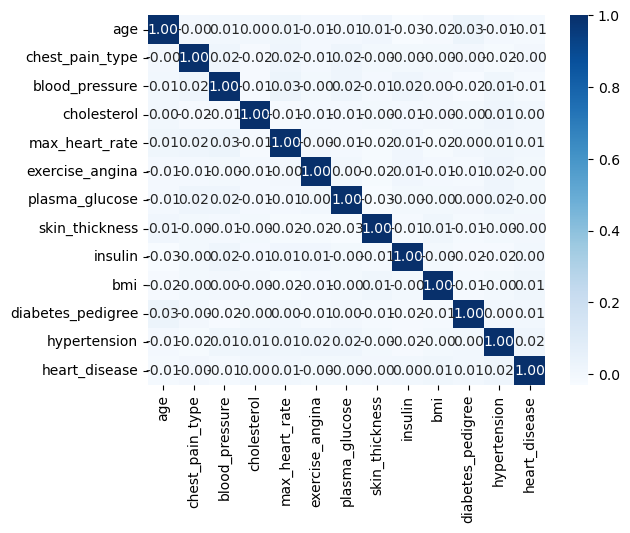

In [29]:
num_cols = ["age", "chest_pain_type","blood_pressure", "cholesterol", "max_heart_rate","exercise_angina","plasma_glucose", "skin_thickness", "insulin", "bmi","diabetes_pedigree","hypertension","heart_disease"]
sns.heatmap(df[num_cols].corr(), cmap='Blues', annot=True,fmt=".2f")

In [30]:
df[num_cols].corr()

,age,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease
age,1.000000,-0.001252,0.005912,0.002531,0.010331,-0.006693,-0.009528,0.006531,-0.030113,-0.016589,0.030123,-0.007514,-0.012946
chest_pain_type,-0.001252,1.000000,0.015930,-0.015811,0.020686,-0.007815,0.015359,-0.003923,-0.003765,-0.004923,-0.000144,-0.019766,-0.001719
blood_pressure,0.005912,0.015930,1.000000,-0.014097,0.026751,-0.002041,0.019334,-0.006215,0.015653,0.001081,-0.023385,0.012825,-0.010335
cholesterol,0.002531,-0.015811,-0.014097,1.000000,-0.014911,-0.006372,-0.006607,-0.002144,-0.008960,-0.001063,-0.002393,0.014846,0.004721
max_heart_rate,0.010331,0.020686,0.026751,-0.014911,1.000000,-0.001935,-0.008550,-0.021662,0.006288,-0.019281,0.003655,0.012177,0.005928
exercise_angina,-0.006693,-0.007815,-0.002041,-0.006372,-0.001935,1.000000,0.004449,-0.019645,0.006823,-0.007434,-0.011022,0.016984,-0.003310
plasma_glucose,-0.009528,0.015359,0.019334,-0.006607,-0.008550,0.004449,1.000000,-0.027354,-0.002037,-0.002233,0.001300,0.021165,-0.002133
skin_thickness,0.006531,-0.003923,-0.006215,-0.002144,-0.021662,-0.019645,-0.027354,1.000000,-0.013156,0.013082,-0.012752,-0.004586,-0.001793
insulin,-0.030113,-0.003765,0.015653,-0.008960,0.006288,0.006823,-0.002037,-0.013156,1.000000,-0.003401,-0.017806,-0.016688,0.004391
bmi,-0.016589,-0.004923,0.001081,-0.001063,-0.019281,-0.007434,-0.002233,0.013082,-0.003401,1.000000,-0.013953,-0.002885,0.011292


c:\Users\boomi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\boomi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\boomi\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\boomi\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

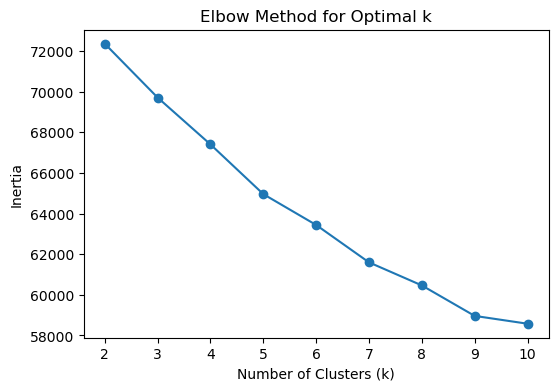

Best k (by silhouette): 9


2025/09/16 21:12:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


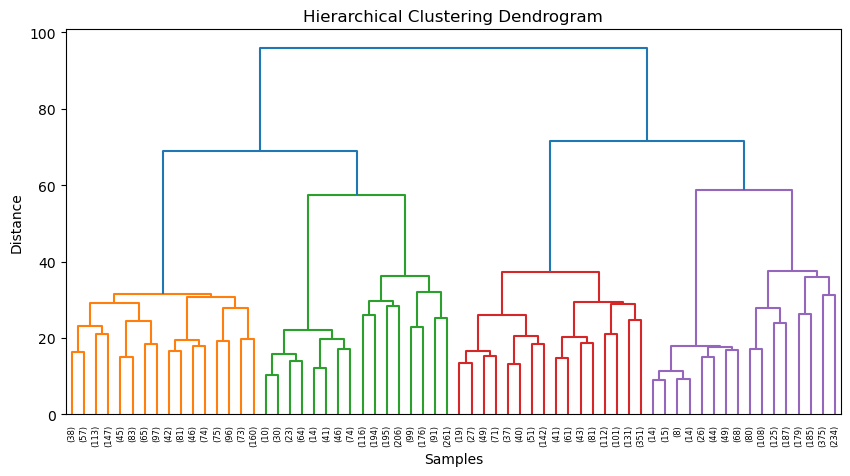

Clustering finished.Check MLflow UI for metrics and models.


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import mlflow.sklearn

df = pd.read_csv("patient_data_cleaned.csv")

df_encoded = pd.get_dummies(df, columns=["smoking_status", "gender", "residence_type"], drop_first=True)

num_cols = ["age", "chest_pain_type","blood_pressure", "cholesterol", "max_heart_rate","exercise_angina","plasma_glucose", "skin_thickness", "insulin", "bmi","diabetes_pedigree","hypertension"]

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

X = df_encoded.drop(columns=["heart_disease"])
y_true = df_encoded["heart_disease"]

inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

best_k = K[np.argmax(sil_scores)]
print("Best k (by silhouette):", best_k)
mlflow.set_experiment("Patient_Clustering")

with mlflow.start_run():
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    sil_km = silhouette_score(X, kmeans_labels)
    dbi_km = davies_bouldin_score(X, kmeans_labels)
    ari_km = adjusted_rand_score(y_true, kmeans_labels)

    mlflow.log_param("KMeans_best_k", best_k)
    mlflow.log_metric("KMeans_Silhouette", sil_km)
    mlflow.log_metric("KMeans_DBI", dbi_km)
    mlflow.log_metric("KMeans_ARI", ari_km)
    mlflow.sklearn.log_model(kmeans,name="KMeans_Model")

    hier = AgglomerativeClustering(n_clusters=best_k)
    hier_labels = hier.fit_predict(X)

    sil_hc = silhouette_score(X, hier_labels)
    dbi_hc = davies_bouldin_score(X, hier_labels)
    ari_hc = adjusted_rand_score(y_true, hier_labels)

    mlflow.log_metric("Hier_Silhouette", sil_hc)
    mlflow.log_metric("Hier_DBI", dbi_hc)
    mlflow.log_metric("Hier_ARI", ari_hc)

    plt.figure(figsize=(10, 5))
    Z = linkage(X, method="ward")
    dendrogram(Z, truncate_mode="level", p=5)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

    dbscan = DBSCAN(eps=1.5, min_samples=5)
    db_labels = dbscan.fit_predict(X)

    if len(set(db_labels)) > 1: 
        sil_db = silhouette_score(X, db_labels)
        dbi_db = davies_bouldin_score(X, db_labels)
        ari_db = adjusted_rand_score(y_true, db_labels)
    else:
        sil_db, dbi_db, ari_db = -1, -1, -1

    mlflow.log_param("DBSCAN_eps", 1.5)
    mlflow.log_metric("DBSCAN_Silhouette", sil_db)
    mlflow.log_metric("DBSCAN_DBI", dbi_db)
    mlflow.log_metric("DBSCAN_ARI", ari_db)

print("Clustering finished.Check MLflow UI for metrics and models.")


In [32]:
from sklearn.decomposition import PCA

df = pd.read_csv("patient_data_cleaned.csv")
df_encoded = pd.get_dummies(df, columns=["smoking_status", "gender", "residence_type"], drop_first=True)

num_cols = ["age", "chest_pain_type","blood_pressure", "cholesterol", 
            "max_heart_rate","exercise_angina","plasma_glucose", 
            "skin_thickness", "insulin", "bmi","diabetes_pedigree","hypertension"]

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

X = df_encoded.drop(columns=["heart_disease"]).values
y_true = df_encoded["heart_disease"].values

pca = PCA(n_components=7, random_state=42)
X_pca = pca.fit_transform(X)

datasets = {"Original": X, "PCA": X_pca}  

mlflow.set_experiment("Patient_Clustering_PCA")

for dataset_name, X_data in datasets.items():   
    with mlflow.start_run(run_name=f"{dataset_name}_Clustering"):   
        K_range = range(2, 11)
        sil_scores, inertia = [], []
        for k in K_range:
            km = KMeans(n_clusters=k, random_state=42)
            labels = km.fit_predict(X_data)
            inertia.append(km.inertia_)
            sil_scores.append(silhouette_score(X_data, labels))
            mlflow.log_metric(f"{dataset_name}_KMeans_Silhouette_k{k}", sil_scores[-1])
            mlflow.log_metric(f"{dataset_name}_KMeans_Inertia_k{k}", inertia[-1])

        best_k = K_range[np.argmax(sil_scores)]
        mlflow.log_param(f"{dataset_name}_KMeans_best_k", best_k)
        kmeans = KMeans(n_clusters=best_k, random_state=42)
        kmeans_labels = kmeans.fit_predict(X_data)

        mlflow.log_metric(f"{dataset_name}_KMeans_Final_Silhouette", silhouette_score(X_data, kmeans_labels))
        mlflow.log_metric(f"{dataset_name}_KMeans_Final_DBI", davies_bouldin_score(X_data, kmeans_labels))
        mlflow.log_metric(f"{dataset_name}_KMeans_Final_ARI", adjusted_rand_score(y_true, kmeans_labels))

        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.6)
        plt.title(f"KMeans Clusters ({dataset_name}, k={best_k})")
        fname = f"{dataset_name}_kmeans_clusters.png"
        plt.savefig(fname)
        mlflow.log_artifact(fname)
        plt.close()

        HC_range = range(2, 11)
        sil_hc_scores = []
        for k in HC_range:
            hc = AgglomerativeClustering(n_clusters=k)
            labels = hc.fit_predict(X_data)
            sil_hc_scores.append(silhouette_score(X_data, labels))

        best_hc_k = HC_range[np.argmax(sil_hc_scores)]
        mlflow.log_param(f"{dataset_name}_Hier_best_k", best_hc_k)

        hier = AgglomerativeClustering(n_clusters=best_hc_k)
        hier_labels = hier.fit_predict(X_data)

        mlflow.log_metric(f"{dataset_name}_Hier_Silhouette", silhouette_score(X_data, hier_labels))
        mlflow.log_metric(f"{dataset_name}_Hier_DBI", davies_bouldin_score(X_data, hier_labels))
        mlflow.log_metric(f"{dataset_name}_Hier_ARI", adjusted_rand_score(y_true, hier_labels))

        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap="Accent", alpha=0.6)
        plt.title(f"Hierarchical Clusters ({dataset_name}, k={best_hc_k})")
        fname = f"{dataset_name}_hier_clusters.png"
        plt.savefig(fname)
        mlflow.log_artifact(fname)
        plt.close()

        best_eps, best_sil = None, -1
        eps_values = np.arange(0.5, 3.1, 0.5)  

        for eps in eps_values:
            db = DBSCAN(eps=eps, min_samples=5)
            db_labels = db.fit_predict(X_data)

            if len(set(db_labels)) > 1:
                sil = silhouette_score(X_data, db_labels)
                mlflow.log_metric(f"{dataset_name}_DBSCAN_Silhouette_eps{eps}", sil)
                mlflow.log_metric(f"{dataset_name}_DBSCAN_DBI_eps{eps}", davies_bouldin_score(X_data, db_labels))
                mlflow.log_metric(f"{dataset_name}_DBSCAN_ARI_eps{eps}", adjusted_rand_score(y_true, db_labels))

                if sil > best_sil:
                    best_sil, best_eps, best_labels = sil, eps, db_labels

        if best_eps:
            mlflow.log_param(f"{dataset_name}_DBSCAN_best_eps", best_eps)
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap="plasma", alpha=0.6)
            plt.title(f"DBSCAN Clusters ({dataset_name}, eps={best_eps})")
            fname = f"{dataset_name}_dbscan_clusters.png"
            plt.savefig(fname)
            mlflow.log_artifact(fname)
            plt.close()

        methods = {
            "KMeans": silhouette_score(X_data, kmeans_labels),
            "Hierarchical": silhouette_score(X_data, hier_labels),
            "DBSCAN": best_sil if best_eps else -1
        }
        best_method = max(methods, key=methods.get)

        mlflow.log_param(f"{dataset_name}_Best_Clustering_Method", best_method)
        mlflow.log_metric(f"{dataset_name}_Best_Silhouette_Overall", methods[best_method])
